# Práctica EigenFaces
## Gabriel Daniel Aguilar Luna, Zuriel Uzai Rodrígez Agiss
### _Facultad de Ingenierría, Universidad Nacional Autónoma de México_
### _Ciudad de México, México_
#### gabriel.aguilar@ingenieria.unam.edu,  zurieluzai2015@gmail.com

***

### __Desarrollo__

##### Imports y funciones

In [1]:
import sys
import numpy as np
import os, random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
original_images = []
basedir = './rawdata/'
files = []
for i in range(200):
    file = random.choice([x for x in os.listdir(basedir) if os.path.isfile(os.path.join(basedir, x))])
    if file not in files:
        files.append(file)
        with open(basedir+file, 'rb') as image_file:
            original_images.append(np.array(Image.frombytes("L", (128, 128), image_file.read())))
    

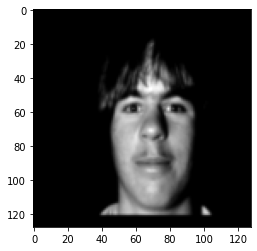

In [3]:
plt.imshow(original_images[0], cmap='gray')
plt.show()

In [4]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for (i, image) in enumerate(original_images):
    r, c = image.shape[0], image.shape[1]    
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)
    
print("\n==> Least common image size:", min_rows, "x", min_cols, "pixels")


==> Least common image size: 128 x 128 pixels


In [5]:
def recenter(image, min_rows, min_cols):
    r, c = image.shape
    top, bot, left, right = 0, r, 0, c
    if r > min_rows:
        top = r - min_rows  
    if c > min_cols:
        right = min_cols     
    return image[top:bot, left:right]

image0_recentered = recenter(image0, min_rows, min_cols)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
imshow_gray(image0, ax=axs[0])
imshow_gray(image0_recentered, ax=axs[1])

NameError: name 'image0' is not defined



### Referencias:

https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/
https://pillow.readthedocs.io/en/stable/reference/Image.html